### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd 'drive/MyDrive/IIT J Summer Internship 2022/Code/Neural-Uncertainty-Representation/'

### Importing Necessary Libraries


In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import os

### Importing Data
We import the data of a young subject's 3D-Tensor Data of dimensions (TR, Voxel, Number of Subjects) for the 5 different ROIs as follows:
- **Prefrontal areas:** dlPFC, vlPFC, lOFC, dmPFC, mPFC, mOFC



In [ ]:
file_names = [name for name in os.listdir('/content/drive/MyDrive/IIT J Summer Internship 2022/Hitchcock/Data/YOUNG/Voxel_BOLD/Numpy') if name.endswith("npy") and ("(1)" not in name) and ("PFC" in name) or ("OFC" in name)]
file_names = [name for name in file_names if ("537" not in name)]

In [ ]:
ROI_names = [file_name.replace("data_","").replace(".npy","") for file_name in file_names]

In [ ]:
data_ori = list()
for file_name in file_names:
  data_ori.append(np.load('/content/drive/MyDrive/IIT J Summer Internship 2022/Hitchcock/Data/YOUNG/Voxel_BOLD/Numpy/'+file_name))

### Data Preparation

Now, here we prepare the data to be fed to the Neural Network Architechtures. We can't predict the time ahead upto which the subjects are predicting correctly so, we will take a bit round about way to predict the BOLD values ahead in time(for several choices of time points e.g. 1 time point ahead, 2 time point ahead, etc) and will compare the results for young and old subjects.

We will start a basic data preparation where we will average across all the voxels for a ROI and fit the model which predicts this average BOLD value. Later we will avoid doing an average since, all voxels in a ROI is not equally important and hence we will want to predict the BOLD values of several voxels simultaneously.

In [ ]:
data = [np.mean(dat, axis=1, keepdims=True) for dat in data_ori]

Let's Start the Data Preparation for lOFC later we will iterate the same procedure for the other ROIs.

In [ ]:
data[-1].shape

(189, 1, 111)

Text(0.5, 1.0, 'Average BOLD for lOFC')

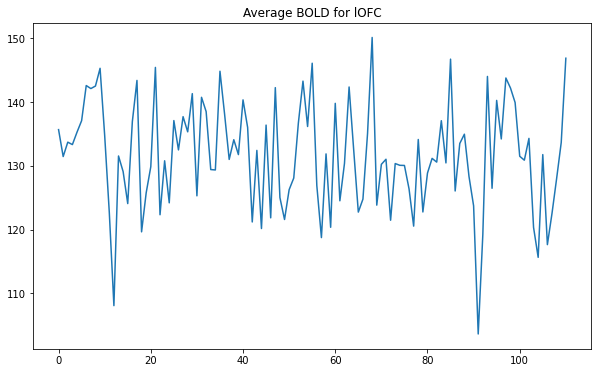

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data[-1][0,0,:])
plt.title("Average BOLD for "+ROI_names[-1])

We have changed the data in the form (Number of Subjects, TR, Voxels) below.

In [ ]:
data = [np.transpose(dat, (2,0,1)) for dat in data]

In [ ]:
data[-1].shape

(111, 189, 1)

We split the dataset of 111 young subjects into 110 subjects in the training data and 1 subject in the test data.

In [ ]:
train_data_unscaled = data[-1][:-1]
test_data_unscaled = np.expand_dims(data[-1][-1], axis=0)  

We scaled the BOLD values of each voxel in the train data between 0 and 1 for each voxel. We use the same MinMaxScaler fit on the train data on the test data.

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
train_data = sc.fit_transform(train_data_unscaled[:,:,0])
test_data = sc.transform(test_data_unscaled[:,:,0])

In [ ]:
train_data = np.expand_dims(train_data, axis = -1)
test_data = np.expand_dims(test_data, axis = -1)

In [ ]:
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (110, 189, 1)
Test Data Shape:  (1, 189, 1)


We now build a data generator which would produce mini-batches during the training of the neural network.

In [ ]:
class KerasBatchGenerator(object):
    def __init__(self, data, num_TRs, batch_size, look_ahead=1):
        self.data = data
        self.num_TRs = num_TRs
        self.batch_size = batch_size
        self.current_idx = 0
        self.look_ahead = look_ahead

    def generate(self):
        while True:
            if self.current_idx + self.batch_size >= self.data.shape[0]:
              self.current_idx = 0
            x = self.data[self.current_idx:(self.current_idx+self.batch_size),:(-self.look_ahead),:]
            y = self.data[self.current_idx:(self.current_idx+self.batch_size),self.look_ahead:,:]
            self.current_idx = self.current_idx + self.batch_size
            yield x, y 

In [ ]:
train_data_generator = KerasBatchGenerator(train_data, train_data.shape[1], 16, 1)
test_data_generator = KerasBatchGenerator(test_data, test_data.shape[1], 1, 1)

In [ ]:
batch_x, batch_y = next(train_data_generator.generate())
print("Train Batch X Shape: ", batch_x.shape)
print("Train Batch y Shape: ", batch_y.shape)

Train Batch X Shape:  (16, 188, 1)
Train Batch y Shape:  (16, 188, 1)


In [ ]:
batch_x, batch_y = next(test_data_generator.generate())
print("Test Batch X Shape: ", batch_x.shape)
print("Test Batch y Shape: ", batch_y.shape)

Test Batch X Shape:  (1, 188, 1)
Test Batch y Shape:  (1, 188, 1)


### Building Model

We will start off by building a Single Layer Deep LSTM Model.

In [ ]:
model = Sequential()
model.add(LSTM(16, return_sequences=True))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(1)))

In [ ]:
model.build(input_shape=test_data.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 189, 16)              1152      
                                                                 
 dropout (Dropout)           (1, 189, 16)              0         
                                                                 
 time_distributed (TimeDistr  (1, 189, 1)              17        
 ibuted)                                                         
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# I am already trained the model hence I commented the following lines
# model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
# num_epochs = 100
# checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="./Models/LSTM-H16-lOFC/", verbose=1)

In [ ]:
# with tf.device('/device:GPU:0'):
#     model.fit_generator(train_data_generator.generate(), train_data.shape[0]//16, num_epochs,
#                         validation_data=test_data_generator.generate(),
#                         validation_steps=test_data.shape[0]//1, callbacks=[checkpointer])

In [ ]:
preds = model.predict(test_data)

Text(0.5, 1.0, "Average BOLD for Last Subject's lOFC")

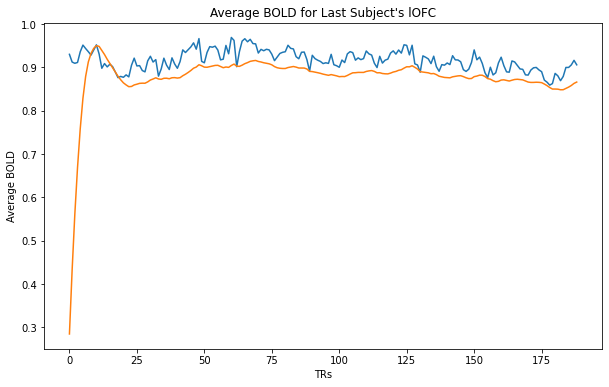

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.squeeze(test_data))
plt.plot(np.squeeze(preds))
plt.ylabel("Average BOLD")
plt.xlabel("TRs")
plt.title("Average BOLD for Last Subject's "+ROI_names[-1])